#Locally adaptive Bayesian covariance regression:
## Integration test

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](https://www.researchgate.net/profile/David_Dunson/publication/232063211_Locally_adaptive_factor_processes_for_multivariate_time_series/links/09e4150df41e8d582a000000.pdf).

## Test data set

The description in the paper is a bit sketchy, but we are following Section 4.1.

In [71]:
using PyPlot
plt.style[:use]("ggplot")
srand(12347)

### Set parameters

In [2]:
Np = 5  # dimension of observation 
NL = 2  # Left dimension of \Theta
NK = 2  # Right dimension of \Theta

2

### Make $\xi(t)$

The $\Xi(t)$ matrix is $L \times K$. Each $\xi_{lk}(t), t \in [0, 1]$ is like a "bumps" function from [Donoho and Johnstone (1994)](http://biomet.oxfordjournals.org/content/81/3/425.short).

In [60]:
tobs = collect(0:0.01:1)  # observation points

# bump kernel function
function K_bumps(t::Float64)
    return (1 + abs(t))^-4
end

# make weighted kernel function
function make_curve(nbumps, kern, max_scale, weight_range, tobs)
    kern_locs = sort(rand(nbumps))
    kern_scales = max_scale * rand(nbumps)
    kern_list = [(t -> kern((t - ti) / s)) for (ti, s) in zip(kern_locs, kern_scales)]
    w_min, w_max = weight_range
    weights = w_min + (w_max - w_min) * rand(nbumps)
    K_mat = [f(t) for f in kern_list, t in tobs]
    return weights' * K_mat
end

make_curve (generic function with 1 method)

(1001,)


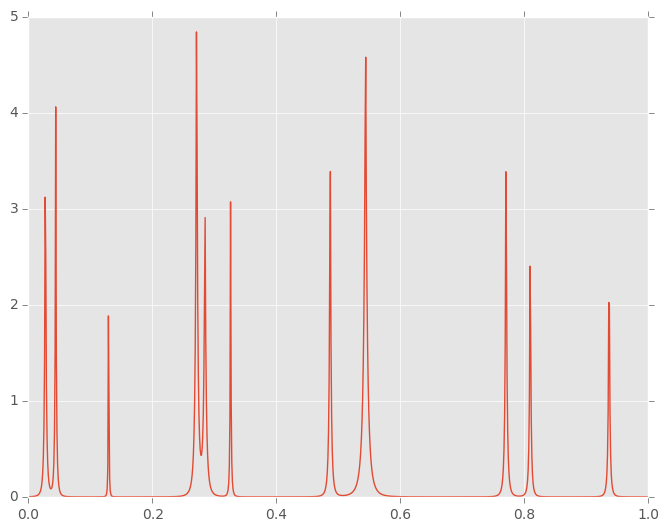

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b8364710>

In [76]:
tobs = collect(0:0.001:1)
println(size(tobs))

bumps = make_curve(11, K_bumps, 0.01, (3, 6), tobs)

plot(tobs, bumps')

### Make $\psi(t)$

The $K$-vector $\Psi(t)$ is the mean of each dictionary element, drawn from a Gaussian process with standard $e^{-|x-x'|^2}$ kernel.